In [1]:
import argparse
import tensorflow as tf
import numpy as np
from utils.classifier import Classifier
from utils import transd_process
from utils import hop_utils as hopu
from utils import sp_utils as spu
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import pysnooper
import warnings
warnings.filterwarnings('ignore')

### 参数设置

In [2]:
def parse_args():
    '''
    Parses the arguments.
    '''
    parser = argparse.ArgumentParser(description="Run ANGAE.")

    parser.add_argument('--dataset', nargs='?', default='cora',
                        help='Input dataset')

    parser.add_argument('--lr', type=float, default=0.0001,
                        help='Learning rate. Default is 0.0001.')

    parser.add_argument('--n-epochs', default=200, type=int,
                        help='Number of epochs')

    parser.add_argument('--hidden_dims', type=list, nargs='+', default=[512, 128],
                        help='Number of dimensions.')



    parser.add_argument('--K', default=3, type=int,
                        help='k-hops')   
    parser.add_argument('--beta', default=0.5, type=int,
                        help='beta') 
    parser.add_argument('--lambd1', default=10, type=int,
                        help='lambd1')    
    parser.add_argument('--lambd2', default=50, type=int,
                        help='lambd2')  
    parser.add_argument('--seed', default=10, type=int,
                        help='seed')        
    #return parser.parse_args()
    return parser.parse_args(args=[]) # jupyter 使用paraer的方法 必须(args=[])
#调用
args = parse_args()  
print(args)

Namespace(K=3, beta=0.5, dataset='cora', hidden_dims=[512, 128], lambd1=10, lambd2=50, lr=0.0001, n_epochs=200, seed=10)


### 加载数据

In [3]:
adj, X, Y, idx_train, idx_val, idx_test,X_target = transd_process.load_data(args.dataset)


In [4]:
#观察数据
print(X.shape,Y.shape,type(X),type(X_target),type(Y), Y.shape)
print(type(adj),adj.shape)
print(idx_train)
print(idx_val)
print(len(idx_test))
print(len(adj.row)/2)

(2708, 1433) (2708, 7) <class 'numpy.matrix'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> (2708, 7)
<class 'scipy.sparse.coo.coo_matrix'> (2708, 2708)
range(0, 140)
range(140, 640)
1000
5278.0


In [5]:
# prepare the data
adj_tf, row,col = transd_process.prepare_graph_data(adj)
print(type(adj_tf),type(row),type(col))
print(adj_tf)
print(row)
print(col)

<class 'tuple'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
(array([[   0,    0],
       [   0,  633],
       [   0, 1862],
       ...,
       [2707, 1473],
       [2707, 2706],
       [2707, 2707]], dtype=int32), array([1., 1., 1., ..., 1., 1., 1.], dtype=float32), (2708, 2708))
[   0  633 1862 ... 1473 2706 2707]
[   0    0    0 ... 2707 2707 2707]


In [6]:
# 隐藏层
feature_dim = X.shape[1]
args.hidden_dims = [feature_dim] + args.hidden_dims
print(args.hidden_dims)

[1433, 512, 128]


### Model

In [7]:
class GATRE():
    def __init__(self, args,A):
        tf.reset_default_graph()
        tf.set_random_seed(args.seed)
        np.random.seed(args.seed)
        
        
        self.args = args
        #self.lambda_ = args.lambda_
        self.n_layers = len(args.hidden_dims) -1

        self.build_placeholders()
        self.W, self.v = self.define_weights(args.hidden_dims)
        self.C = {}
        hops = hopu.get_hops(A, args.K)
        #k-hops邻居节点个数  dict,scale_terms[-1] 为按节点号为顺序号的节点 不可达的节点数
        scale_terms = {h if h != -1 else max(hops.keys()) + 1:
                           hops[h].sum(1).A1 if h != -1 else hops[1].shape[0] - hops[h].sum(1).A1
                       for h in hops}
        

        self.__dataset_generator(hops, scale_terms)
        
        self.build_model()

        self.build_loss()
        

    def build_placeholders(self):
        self.A = tf.sparse_placeholder(dtype=tf.float32)
        self.X = tf.placeholder(dtype=tf.float32)
        self.row = tf.placeholder(tf.int64)
        self.col = tf.placeholder(tf.int64)  

    def define_weights(self, hidden_dims):
        W = {}
        for i in range(self.n_layers):
            W[i] = tf.get_variable("W%s" % i, shape=(hidden_dims[i], hidden_dims[i+1]))

        Ws_att = {}
        for i in range(self.n_layers):
            v = {}
            v[0] = tf.get_variable("v%s_0" % i, shape=(hidden_dims[i+1], 1))
            v[1] = tf.get_variable("v%s_1" % i, shape=(hidden_dims[i+1], 1))
            Ws_att[i] = v

        return W, Ws_att
    
    def build_model(self):
        # Encoder
        H = self.X
        for layer_i in range(self.n_layers):
            H = self.__encoder(self.A, H, layer_i)

        # Final node representations
        self.H = H
        
        for layer_i in range(self.n_layers - 1, -1, -1):
            H = self.__decoder(H, layer_i)
        #reconstruct X
        self.X_ = H
        
    def build_loss(self):
            self.__build_tri_loss()
            
            self.features_loss = tf.sqrt(tf.reduce_sum(tf.reduce_sum(tf.pow(self.X - self.X_, 2),axis=-1)))
            # The reconstruction loss of the graph structure
            S_emb = tf.nn.embedding_lookup(self.H, self.row)
            R_emb = tf.nn.embedding_lookup(self.H, self.col)

            sim = self.__sim(S_emb,R_emb)
            
            structure_loss = -tf.log(sim)
            self.structure_loss = tf.reduce_sum(structure_loss)/self.args.lambd1#10
            self.loss = self.features_loss +  self.loss_tri + self.structure_loss        
            
    def __build_tri_loss(self):
        hop_pos = tf.stack([self.triplets[:, 0], self.triplets[:, 1]], 1)
        hop_neg = tf.stack([self.triplets[:, 0], self.triplets[:, 2]], 1)
        anchor = tf.gather(self.H,hop_pos[:,0])
        pos = tf.gather(self.H,hop_pos[:,1])
        neg = tf.gather(self.H,hop_neg[:,1])
        
        sim_p = self.__sim(pos,anchor)
        sim_n = self.__sim(neg,anchor)
        loss_0 = -sim_p+sim_n+self.args.beta #0.5
        loss_tri = tf.gather(loss_0,tf.where(tf.greater(loss_0,0)))
        self.loss_tri = tf.reduce_sum(loss_tri)/self.args.lambd2 #/100 #20#100
        
    def __sim(self,n1,n2):
        #self.features_loss = tf.sqrt(tf.reduce_sum(tf.reduce_sum(tf.pow(self.X - self.X_, 2),axis=-1)))
        fz = tf.reduce_sum(n1 * n2,axis=-1)
        fm1 = tf.sqrt(tf.reduce_sum(tf.pow(n1,2),axis=-1))
        fm2 = tf.sqrt(tf.reduce_sum(tf.pow(n2,2),axis=-1))
        fm = fm1*fm2
        return fz/fm
    def __dataset_generator(self, hops, scale_terms):
        def gen():
            while True:
                yield hopu.to_triplets(hopu.sample_all_hops(hops), scale_terms)

        dataset = tf.data.Dataset.from_generator(gen, (tf.int32, tf.float32), ([None, 3], [None]))
        self.triplets, self.scale_terms = dataset.prefetch(1).make_one_shot_iterator().get_next()
        
    def train(self, A,X,row,col,gpu= True):
        
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        if gpu == False:
            config.intra_op_parallelism_threads = 0
            config.inter_op_parallelism_threads = 0
        self.session = tf.Session(config=config)
        
        self.train_op = tf.train.AdamOptimizer(learning_rate=self.args.lr).minimize(self.loss)
        
        self.session.run([tf.global_variables_initializer(), tf.local_variables_initializer()])
        
        for epoch in range(self.args.n_epochs):
            loss,_,l_x,l_s,l_t = self.session.run([self.loss,self.train_op,self.features_loss,\
                                          self.structure_loss,self.loss_tri],
                                             feed_dict={self.A: A,
                                                        self.X: X,
                                                        self.row: row,
                                                        self.col: col})

            print("Epoch: %s, Loss: %.2f, X_Loss:%.2f, S_Loss:%.2f, T_Loss:%.2f" % (epoch, loss,l_x,l_s,l_t))
        return loss,self.session
        

    def infer(self, A,X,row,col):
        H, C = self.session.run([self.H, self.C],
                           feed_dict={self.A: A,
                                      self.X: X,
                                      self.row: row,
                                      self.col: col})
        return H, spu.conver_sparse_tf2np(C)
    def __encoder(self, A, H, layer_i):

        H = tf.matmul(H, self.W[layer_i])
        self.C[layer_i] = self.graph_attention_layer(A, H, self.v[layer_i], layer_i)
        return tf.sparse_tensor_dense_matmul(self.C[layer_i], H)
    #@pysnooper.snoop()
    def __decoder(self, H, layer_i):
        H = tf.matmul(H, self.W[layer_i], transpose_b=True)
        return H

    def graph_attention_layer(self, A, M, v, layer):
        with tf.variable_scope("layer_%s"% layer):
            f1 = tf.matmul(M, v[0])
            f1 = A * f1
            f2 = tf.matmul(M, v[1])
            f2 = A * tf.transpose(f2, [1, 0])
            logits = tf.sparse_add(f1, f2)

            unnormalized_attentions = tf.SparseTensor(indices=logits.indices,
                                         values=tf.nn.sigmoid(logits.values),
                                         dense_shape=logits.dense_shape)
            attentions = tf.sparse_softmax(unnormalized_attentions)

            attentions = tf.SparseTensor(indices=attentions.indices,
                                         values=attentions.values,
                                         dense_shape=attentions.dense_shape)

            return attentions    
        

### Train

In [8]:
model = GATRE(args,adj)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    


In [9]:
#loss,sess,l_x,l_s = model.train(adj_tf,X,row,col,gpu= True)
loss,sess = model.train(adj_tf,X_target,row,col,gpu= True)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.
Epoch: 0, Loss: 308.40, X_Loss:144.12, S_Loss:103.53, T_Loss:60.76
Epoch: 1, Loss: 302.14, X_Loss:144.61, S_Loss:93.11, T_Loss:64.42
Epoch: 2, Loss: 297.95, X_Loss:145.11, S_Loss:84.21, T_Loss:68.63
Epoch: 3, Loss: 294.21, X_Loss:145.53, S_Loss:76.81, T_Loss:71.87
Epoch: 4, Loss: 291.74, X_Loss:145.81, S_Loss:70.75, T_Loss:75.18
Epoch: 5, Loss: 288.53, X_Loss:145.91, S_Loss:65.85, T_Loss:76.77
Epoch: 6, Loss: 287.32, X_Loss:145.80, S_Loss:61.95, T_Loss:79.57
Epoch: 7, Loss: 285.95, X_Loss:145.48, S_Loss:58.86, T_Loss:81.61
Epoch: 8, Loss: 283.45, X_Loss:144.98, S_Loss:56.43, T_Loss:82.05
Epoch: 9, Loss: 282.56, X_Loss:144.33, S_Loss:54.53, T_Loss:83.69
Epoch: 10, Loss: 280.24, X_Loss:143.57, S_Loss:53.06, T_Loss:83.61
Epoch: 11, Loss: 279.00, X_Loss:142.74, S_Loss:51.93, T_Loss:84.33
Epoch: 12, Loss: 277.08, X_Loss:141.

Epoch: 110, Loss: 231.65, X_Loss:118.85, S_Loss:32.86, T_Loss:79.93
Epoch: 111, Loss: 231.42, X_Loss:118.78, S_Loss:32.84, T_Loss:79.80
Epoch: 112, Loss: 231.67, X_Loss:118.72, S_Loss:32.81, T_Loss:80.15
Epoch: 113, Loss: 231.46, X_Loss:118.65, S_Loss:32.79, T_Loss:80.03
Epoch: 114, Loss: 230.71, X_Loss:118.58, S_Loss:32.76, T_Loss:79.37
Epoch: 115, Loss: 230.41, X_Loss:118.52, S_Loss:32.74, T_Loss:79.15
Epoch: 116, Loss: 231.15, X_Loss:118.46, S_Loss:32.73, T_Loss:79.96
Epoch: 117, Loss: 230.64, X_Loss:118.40, S_Loss:32.73, T_Loss:79.51
Epoch: 118, Loss: 230.77, X_Loss:118.34, S_Loss:32.73, T_Loss:79.70
Epoch: 119, Loss: 230.85, X_Loss:118.28, S_Loss:32.73, T_Loss:79.85
Epoch: 120, Loss: 230.43, X_Loss:118.22, S_Loss:32.72, T_Loss:79.49
Epoch: 121, Loss: 230.00, X_Loss:118.17, S_Loss:32.71, T_Loss:79.12
Epoch: 122, Loss: 229.79, X_Loss:118.11, S_Loss:32.69, T_Loss:78.99
Epoch: 123, Loss: 230.45, X_Loss:118.05, S_Loss:32.66, T_Loss:79.74
Epoch: 124, Loss: 230.24, X_Loss:117.99, S_Loss:

In [10]:
embeddings, attentions = model.infer(adj_tf,X,row,col)

# Evaluate the quality of embeddings
classifier = Classifier(embeddings,Y)


In [11]:

f1_micro, f1_macro = classifier.cross_validation_classify(n_repeat=10, norm=True)
print('Micro_f1: {:.4f}, Macro_f1: {:.4f}'.format(f1_micro, f1_macro))

Micro_f1: 0.8457, Macro_f1: 0.8339


0.9967508669891202


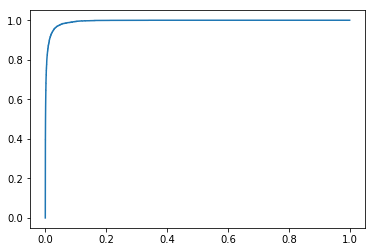

In [12]:
auc_score,_= classifier.auc_ap_scores(adj)
print(auc_score)
fpr, tpr, thresholds = classifier._roc_curve(adj)

plt.plot(fpr,tpr)
plt.show()

In [13]:
print(embeddings.shape)
from sklearn.manifold import TSNE
tsne =  TSNE(n_components=2, learning_rate=100)
data = tsne.fit_transform(embeddings)

(2708, 128)


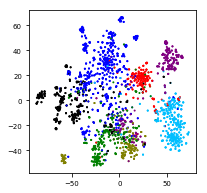

In [14]:


color=[]

C = np.argmax(Y, -1)
for i in range(len(C)):
    
    if C[i] == 0:
        color.append('green')
    if C[i] == 1:
        color.append('red')
    if C[i] == 2:
            color.append('deepskyblue') #blue
    if C[i] == 3:
            color.append('blue')
    if C[i] == 4:
            color.append('black')
    if C[i] == 5:
            color.append('purple')
    if C[i] == 6:
            color.append('olive')        
#fig=plt.figure(figsize=(10,10),facecolor='white') #3,3
#plt.scatter(data[:,0], data[:,1], s=20,c=color)  #1
fig=plt.figure(figsize=(3,3),facecolor='white') #3,3
plt.tick_params(labelsize=7)
plt.scatter(data[:,0], data[:,1], s=1,c=color)  #1
#foo_fig = plt.gcf() # 'get current figure'
#foo_fig.savefig('cora.eps', format='eps', dpi=1000)
#plt.savefig(args.dataset+'.eps')
plt.savefig('%s.eps'%args.dataset)
plt.show()    
